# Validating a first-light TESS result

I'm going to have a quick-look at TESS target TOI-197 to see if I can replicate the basic results of Huber et al. 2019

In [35]:
import lightkurve as lk
import numpy as np
import seaborn as sns
sns.set_context('notebook')

First I'll download the data...

In [36]:
target = 'HIP 116158'

datalist = lk.search_lightcurvefile(target, cadence='short')
datalist

SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  441462736 tess2018234235059-s0002-0000000441462736-0121-s_lc.fits Light curves      0.0

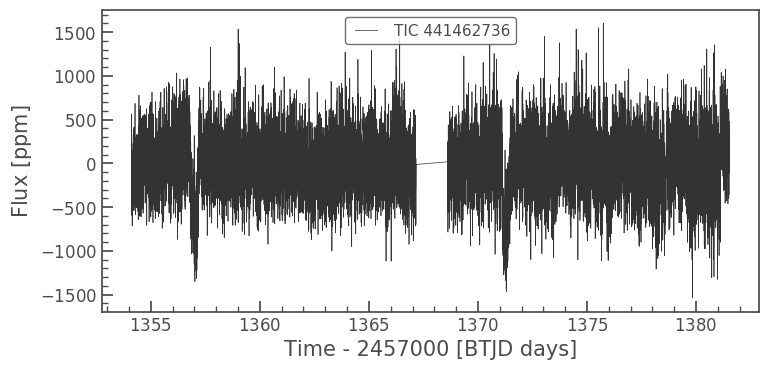

In [37]:
lcraw = datalist.download().PDCSAP_FLUX
lc = lcraw.normalize(unit='ppm').remove_nans().remove_outliers()-1e6
lc.plot();

## Converting to a periodogram

I'll use a Power Spectral Density (psd) normalization on the y-axis, and overplot a smoothed spectrum to see if we can detect any oscillations by eye.

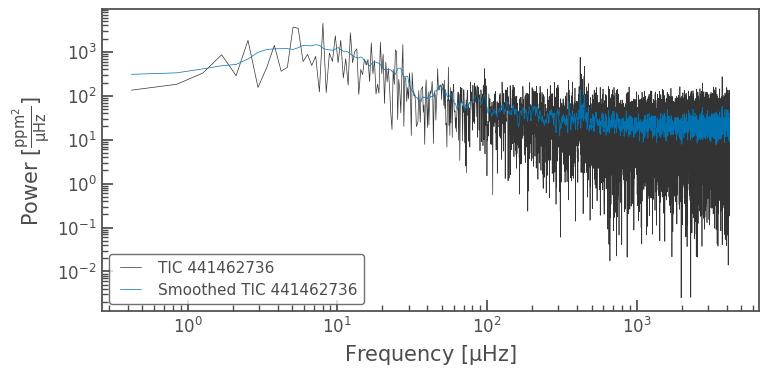

In [38]:
pg = lc.to_periodogram(normalization='psd')
spg = pg.smooth(method='boxkernel', filter_width=5)
spg.label = f'Smoothed {spg.label}'
ax = pg.plot()
spg.plot(ax=ax, scale='log')

There seems to be some excess around ~400 $\mu\rm{Hz}$. Let's see if we can confirm that.

## Using the seismology package

We'll cut off the periodogram at 1000 $\mu\rm{Hz}$ to focus on the region of power excess.

In [39]:
snr = lc.to_periodogram(normalization='psd', minimum_frequency = 100, maximum_frequency=800).flatten()
seis = snr.to_seismology()

Let's estimate $\nu_{\rm max}$ first.

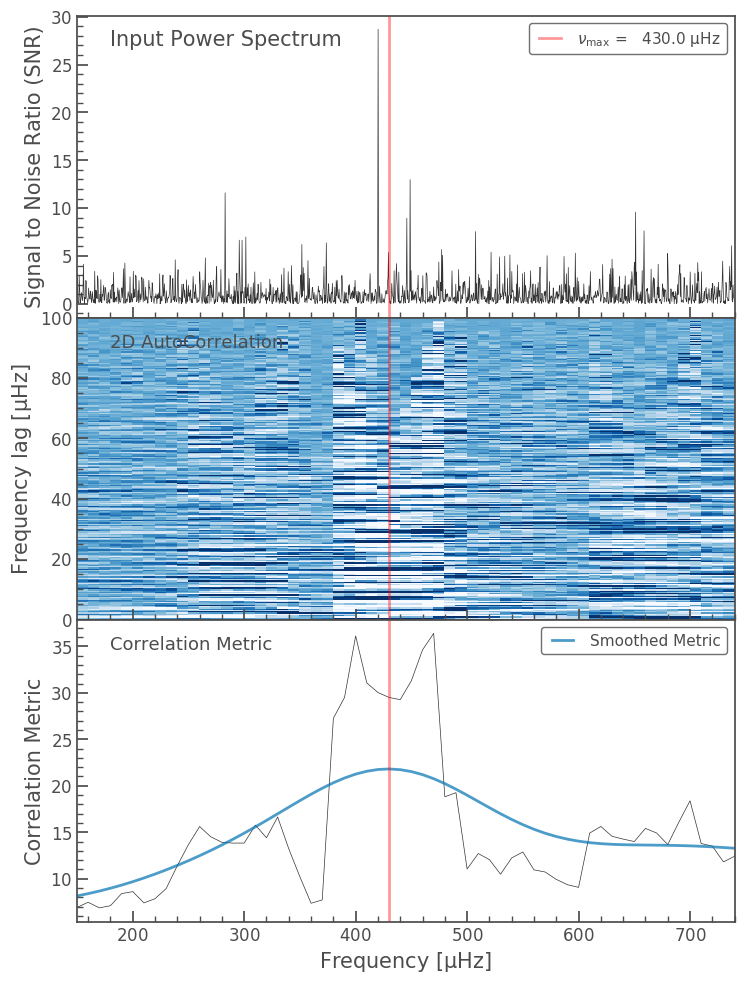

In [40]:
seis.estimate_numax(window_width=100)
seis.diagnose_numax();

And now let's estimate $\Delta\nu$.

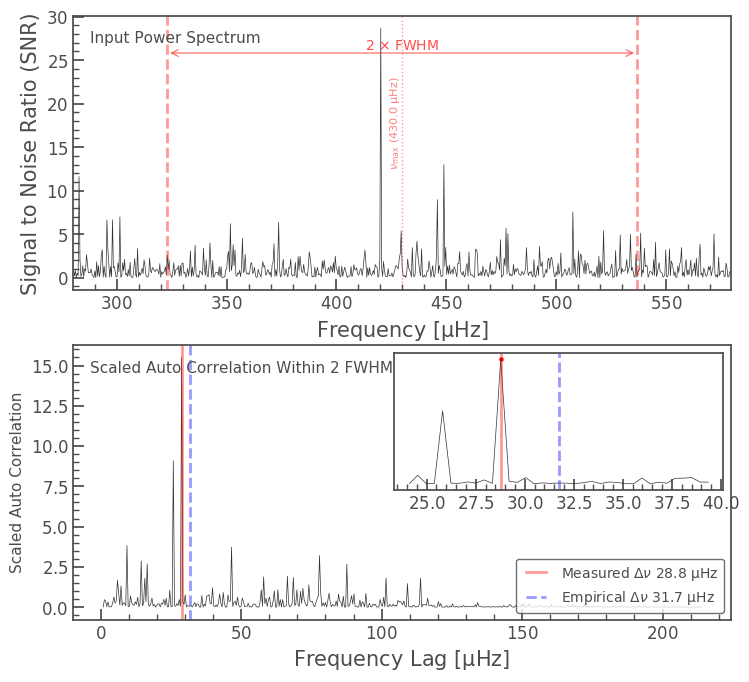

In [41]:
seis.estimate_deltanu()
seis.diagnose_deltanu()

## Comaprisons to Huber et al. 2019

Finally let's print the results compared to those reported for this star.

In [34]:
print(f'numax: {430} +- {18} (Huber+19) vs {seis.numax} (ours)')
print(f'deltanu: {28.94} +- {0.15} (Huber+19) vs {seis.deltanu:.2f} (ours)')

numax: 430 +- 18 (Huber+19) vs 430.0 uHz (ours)
deltanu: 28.94 +- 0.15 (Huber+19) vs 28.78 uHz (ours)
